<a href="https://colab.research.google.com/github/akashsaha06/NeurIPS-2020/blob/main/OpMINRES.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*Author:* Akash Saha

*Affiliation:* Industrial Engineering & Operations Reseach, IIT Bombay

*Email:* akashsaha@iitb.ac.in

This notebook uses Operator based Minimum Residual
(OpMINRES) algorithm to learn a function $\mathcal{F}:\mathcal{X}→\mathcal{Y}$, where $\mathcal{X}$ is an appropriate input space and $\mathcal{Y}$ is an output space of functions using generalized operator-valued kernels. OpMINRES algorithm has been proposed for solving a loss stabilization problem in an induced Reproducing Kernel Krein
Spaces (RKKS) of function-valued functions. A toy problem has been considered in the notebook with a synthetic dataset.

# Importing required packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
import scipy.special as sps
from time import process_time

# Generating Synthetic Data for Toy Problem

In [2]:
def data_generator(N, sigma_x, sigma_y):
    """
    Generate dataset of input functions with weighted cosine function on [0,2pi]
    and the output functions are weighted sixth order Chebychev 
    polynomials of the first kind on [-1,1]. Random weights a, w are used for 
    scaling of 5 components which are shared by input and output functions. The 
    functions are sampled at 100 points on their respective domains.
    
    Parameters
    ----------
    N: int
        Number of input-output functions required in dataset
    sigma_x: float (positive)
        Standard deviation used for introducing noise in input functions
    sigma_y: float (positive)
        Standard deviation used for introducing noise in output functions
    
    Returns
    ----------
    inp_x: list
        List of N input functions sampled at tx points
    tx: array
        Points in the domain of input functions created [0, 2pi]
    out_y: list
        List of N output functions sampled at ty points
    ty: array
        Points in the domain of input functions created [-1, 1]
    """
    sd = 100
    np.random.seed(sd)
    P = 5
    m_x = 100
    m_y = 100
    tx = np.linspace(0, 2*np.pi, m_x)
    ty = np.linspace(-1, 1, m_y)
    p = np.zeros(6)
    p[-1] = 1
    inp = []
    out = []
    for i in range(N):
        w = np.random.uniform(0, 1, P)
        a = np.random.uniform(-1, 1, P)
        xx = np.zeros(m_x)
        yy = np.zeros(m_y)
        for j in range(P):
            xx += a[j]*np.cos(w[j]*tx)
            yy += a[j]*np.polynomial.chebyshev.chebval(w[j]*ty,p)
        xx = xx + np.random.normal(0, sigma_x, m_x)
        yy = yy + np.random.normal(0, sigma_y, m_y)
        xx_new=(1./max(abs(xx)))*xx
        yy_new=(1./max(abs(yy)))*yy
        inp.append(xx_new)
        out.append(yy_new)
    return inp, tx, out, ty

In [3]:
inp, tx, out, ty = data_generator(100, sigma_x=0.02, sigma_y=0.02)

## Visualize samples pairs of input and output functions generated

In [4]:
def visualize_inp_out(inp, tx, out, ty, M):
    v_list = np.random.choice(len(inp), M, replace=False)
    fig, axs = plt.subplots(5, 2, figsize=(12,12))
    fig.suptitle('Samples of Input and Output functions')
    j = 0
    for i in v_list:
        axs[j,0].plot(tx, inp[i], color='orange')
        axs[j,0].set_title('Input [{}]'.format(i))
        axs[j,1].plot(ty, out[i], color='blue')
        axs[j,1].set_title('Output [{}]'.format(i))
        j += 1
    for ax in axs.flat:
        ax.label_outer()

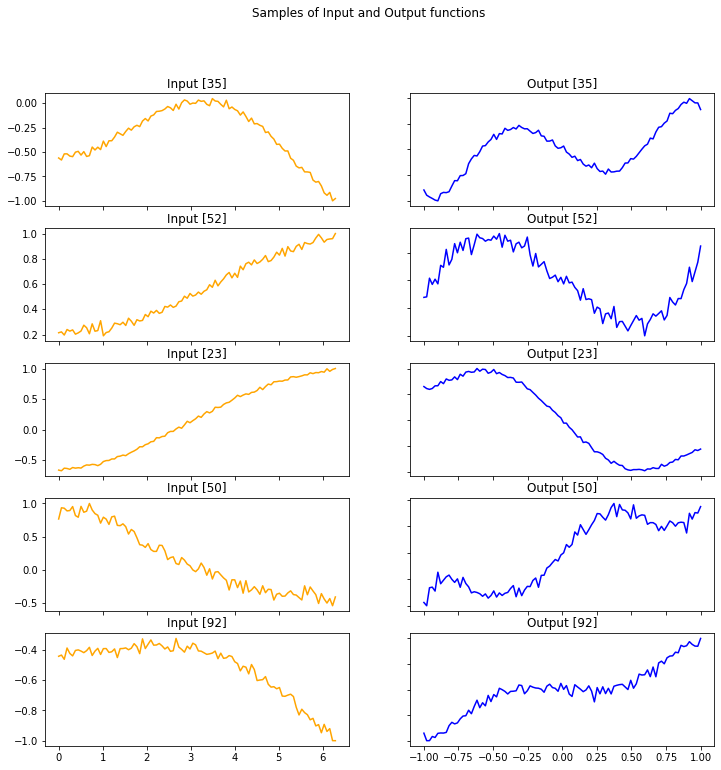

In [5]:
visualize_inp_out(inp, tx, out, ty, 5)

## Splitting into train and test data

In [6]:
train_x = inp[:80]
train_y = out[:80]
test_x = inp[80:]
test_y = out[80:]

# Creating functions for defining basis on input and output spaces

Trignometric basis functions are created for the spaces $\mathcal{X}=L^2[0,2\pi]$ and $\mathcal{Y}=L^2[-1,1]$ corresponding to the input and output functions, respectively.

For $L^2[0,2\pi]$:
$$B=\left\{\frac{1}{\sqrt{2\pi}}, \frac{1}{\sqrt{\pi}}\cos\left(\frac{t}{2}\right), \frac{1}{\sqrt{\pi}}\cos\left(\frac{2t}{2}\right),\dots, \frac{1}{\sqrt{\pi}}\cos\left(\frac{nt}{2}\right),\dots\right\},\, t\in[0,2\pi]$$
For $L^2[-1,1]$:
$$B=\left\{\frac{1}{\sqrt{2}}, \cos\left(\frac{\pi}{2}(t+1)\right), \cos\left(\frac{2\pi}{2}(t+1)\right),\dots,\cos\left(\frac{n\pi}{2}(t+1)\right),\dots\right\}, t\in[-1,1]$$
In addition, the sets of basis functions $B$ are orthonormal in both cases. For practicality, we have used only N number of basis functions.

In [7]:
def trig_basis_x(N, t):
    basis = []
    for i in range(N):
        if i == 0:
            b = (1./np.sqrt(t[-1]-t[0]))*np.ones(len(t))
        else:
            b = np.sqrt(2./(t[-1]-t[0]))*np.cos(np.pi*i*((1./(t[-1]-t[0]))*t-t[0]*np.ones(len(t))))
        basis.append(b)
    return basis

In [8]:
def trig_basis_y(N, t):
    basis = []
    for i in range(N):
        if i == 0:
            b = 1/np.sqrt(2)*np.ones(len(t))
        else:
            b = np.cos((np.pi*i/2)*(t+np.ones(len(t))))
        basis.append(b)
    return basis

# Functions required for calculating inner product and projections w.r.t. basis

In [9]:
def inner_prod(f,g,t):
    s = 0.
    n = len(f)
    x = t
    dx = (t[-1] - t[0])/(n-1)
    fx = f*g
    s = integrate.simps(fx, x, dx, even='avg')  #numerical integration using composite Simpson's rule
    return s

In [10]:
def get_proj_coefs(x, t, basis):
    proj = np.zeros(len(basis))
    for i in range(len(basis)):
        proj[i] = inner_prod(x, basis[i], t)
    return proj

In [11]:
def function_2_basis_rep(x, t, basis):
    fd = get_proj_coefs(x, t, basis)
    return fd

# Functions used for creating operator-valued kernels

In order to specify a generalized operator-valued kernel, the following construction has been used:

$$K(x,z)y(t) = k_{scalar}(x,z)\int_{-1}^{1}(k_{op_1}(t,s)-k_{op_2}(t,s))y(s)ds,$$ where $x,z\in\mathcal{X}, y\in\mathcal{Y}, t\in[-1,1]$, $k_{scalar}:\mathcal{X\times X}→\mathbb{R}$, $k_{op_1}:\mathbb{R}\times\mathbb{R}→\mathbb{R}$, $k_{op_2}:\mathbb{R}\times\mathbb{R}→\mathbb{R}$.

$k_{scalar}$ and $k_{op_1}, k_{op_2}$ are kernel functions defined on $\mathcal{X}$ and $\mathbb{R}$, respectively. In this implementation, we use RBF kernel as $k_{scalar}$ as
$$k_{scalar}(x,z)=e^{-\gamma_{scalar}\|x-z\|_{\mathcal{X}}^2},$$
where $\gamma_{scalar}>0$. As $k_{op}$, we use the following kernel:
$$k_{op_1}(t,s)=e^{-\gamma_{op_1}|t-s|}, k_{op_2}(t,s)=e^{-\gamma_{op_2}|t-s|}.$$

OpMINRES algorithm solves the following problem for $\mathbf{u}$:
$$(\mathbf{K}+\lambda I)\mathbf{u}=\mathbf{y},\,\,\lambda>0$$
where $\mathbf{K}=\begin{bmatrix}K(x_1,x_1)&\dots&K(x_1,x_n)\\\vdots&\ddots&\vdots\\K(x_n,x_1)&\dots&K(x_n,x_n)\end{bmatrix},$ $\mathbf{y}=[y_1\dots,y_n]^T$ for a training set $\left\{(x_i,y_i)\right\}_{i=1}^n$ and $\mathbf{u}\in\mathcal{Y}^n$.

In [12]:
def scalar_kernel(f,g):
    x = np.array(f)
    y = np.array(g)
    r = (np.linalg.norm(x-y))**2 
    return np.exp(-scalar_gamma*r)

In [13]:
def op_kernel(z, basis):
    y = np.zeros(len(basis[0]))
    for i in range(len(basis)):
        y += z[i]*basis[i]
    one = np.ones(len(y))
    X = 0.*y
    for i in range(len(y)):
        s = ty
        dx = ty[-1]/(len(y)-1)
        f = np.multiply(np.exp(-op_gamma_1*np.abs(ty[i]*one-s))-np.exp(-op_gamma_2*np.abs(ty[i]*one-s)),y)
        X[i] = integrate.simps(f, s, dx, even='avg')
    fX = function_2_basis_rep(X, ty, basis)
    return fX

In [14]:
def op_K(u, basis):
    n = len(u)
    K = []
    for i in range(n):
        K.append(op_kernel(u[i], basis))
    return K

In [15]:
def op_dot_A(G, v, basis, Lambda):
    n = len(v)
    Av = np.zeros(v.shape)
    K = op_K(v, basis)
    for i in range(n):
        X = 0.* v[0]
        for j in range(n):
            if i == j:
                X += G[i,j]*(K[j]) + Lambda*(v[j])
            else:
                X += G[i,j]*(K[j])
        Av[i] = X
    return Av

In [16]:
def scalar_G(u):
    n = len(u)
    G = np.zeros((n,n))
    for i in range(n):
        for j in range(n):
            if i <= j:
                G[i][j] = scalar_kernel(u[i], u[j])
            else:
                G[i][j] = G[j][i]
    return G

# Routines required in OpMINRES algorithm

In [17]:
def LanczosStep(G, v1, v0, beta1, basis, Lambda):
    p = op_dot_A(G, v1, basis, Lambda)
    alpha = np.sum(np.multiply(v1,p))
    p = p - alpha*v1
    v2 = p - beta1*v0
    beta2 = np.linalg.norm(v2)
    if (beta2 != 0):
        v2 = (1./beta2)*v2
    return alpha, beta2, v2

In [18]:
def SymOrtho(a, b):
    if (b == 0):
        s = 0
        r = np.abs(a)
        if (a == 0):
            c = 1
        else:
            c = np.sign(a)
    elif (a == 0):
        c = 0
        s = np.sign(b)
        r = np.abs(b)
    elif (np.abs(b) > np.abs(a)):
        tau = a/b
        s = np.sign(b)/np.sqrt(1 + tau**2)
        c = s*tau
        r = b/s
    elif (np.abs(a) > np.abs(b)):
        tau = b/a
        c = np.sign(a)/np.sqrt(1 + tau**2)
        s = c*tau
        r = a/c
    return c, s, r

# OpMINRES Algorithm

In [19]:
def OpMINRES(G, b, maxiter, tol, N, basis, Lambda):
    """
    A Krylov subspace method which solves for u in (K + Lambda I)u = y 
    iteratively by minimizing residual in each iteration. 
    
    Parameters
    ----------
    G: matrix
        Scalar kernel (Gram) matrix based on the k_scalar defined.
    b: matrix
        Contains the encoding of output functions in training set based on the 
        projections obtained using basis of the output space.
    maxiter: int
        Maximum limit of iterations for OpMINRES
    tol: float (positive)
        Tolerance beyond which OpMINRES terminates
    N: int
        Number of basis elements considered for the output space
    basis: list
        List of basis functions obtained from trig_basis_y for the output space
    Lambda: float (positve)
        Lambda in (K + Lambda I)u = y

    Returns
    ----------
    x0: matrix
        Matrix which contains the functions corresponding to u. Contains u_1, 
        u_2, ..., u_n with N samples in each row
    phi0: float
        Residual norm used in stopping criterion
    psi: float
        Residual norm obtained in the orthogonalization process
    chi: float
        Norm of the solution
    k-1: int
        number of iterations completed
    """
    beta1 = np.linalg.norm(b)
    n = len(b)
    v0 = np.zeros((n,N))
    v1 = (1./beta1)*b
    phi0 = beta1
    phi1 = beta1
    phi00 = beta1
    tau = beta1
    chi = 0
    delta1_1 = 0
    epsilon1_1 = 0
    c0 = -1
    s0 = 0
    d1 = np.zeros((n,N))
    d0 = np.zeros((n,N))
    x0 = np.zeros((n,N))
    k = 1
    while (k <= maxiter and phi1/phi00 > tol):
        t0_start = process_time()
        alpha, beta2, v2 = LanczosStep(G, v1, v0, beta1, basis, Lambda)
        #last left orthogonaization on middle two entries in last column of T_k
        delta1_2 = c0*delta1_1 + s0*alpha
        gamma1_1 = s0*delta1_1 - c0*alpha
        #last left orthogonalization to produce first two entries of T_k+1e_k+1
        epsilon2_1 = s0*beta2
        delta2_1 = -c0*beta2
        #current left orthogonalization to zero out beta_k+1
        c1, s1, gamma1_2 = SymOrtho(gamma1_1, beta2)
        #right-hand side, residual norms
        tau = c1*phi0
        phi1 = s1*phi0
        psi0 = phi0*np.sqrt(gamma1_1**2 + delta2_1**2)
        if (gamma1_2 != 0):
            d2 = (1./gamma1_2)*(v1 - delta1_2*d1 - epsilon1_1*d0)
            x1 = x0 + tau*d2
            chi = np.linalg.norm(x1)
        k = k + 1
        v0 = v1
        v1 = v2
        beta1 = beta2
        c0 = c1
        s0 = s1
        phi0 = phi1
        delta1_1 = delta2_1
        epsilon1_1 = epsilon2_1
        x0 = x1
        d0 = d1
        d1 = d2
        psi = phi0*np.sqrt(gamma1_1**2 + delta2_1**2)
        t0_stop = process_time()
        print("Iteration ", k-1," completed in ", t0_stop-t0_start,"s")
    print("OpMINRES complete")
    return x0, phi0, psi, chi, k-1

# Functions required for testing and evaluation

For the testing phase, we use the following based on the representer theorem:
$$\mathcal{F}(\hat{x})=\sum_{i=1}^nK(x_i,\hat{x})u_i,$$
where $u_i$'s are obtained from OpMINRES and $\hat{x}$ is an input function from the test data.

As error metric for evaluating output functions residual sum of squares error (RSSE) is used which is given by
$$RSSE(y,\hat{y})=∫_{-1}^1\sum_i\left(y_i(t)-\hat{y}_i(t)\right)^2.$$

In [20]:
def test_evaluate(r, y_coefs, basis):
    S = 0.*basis[0]
    for i in range(r):
        S += y_coefs[i]*basis[i]
    return S

In [21]:
def test(train_x, u, test_data, basis):
    n = len(u)
    Ku = []
    for i in range(n):
        Ku.append(op_kernel(u[i], basis))
    c = np.zeros((len(test_data), len(train_x)))
    for i in range(len(test_data)):
        for j in range(len(train_x)):
            c[i][j] = scalar_kernel(train_x[j], test_data[i])
    test_output = []
    coef_output = np.zeros((len(test_data), len(Ku[0])))
    for i in range(len(test_data)):
        coef = np.zeros(Ku[0].shape)
        for j in range(len(Ku)):
            coef += c[i][j]*Ku[j]
        coef_output[i] = coef
        test_output.append(test_evaluate(N, coef, basis))
    return test_output, coef_output

In [22]:
def error_rsse_coef(test_output_coef, enc_test_y):
    err = np.linalg.norm(test_output_coef-enc_test_y)
    return err

In [23]:
def error_rsse(test_output, test_y, t):
    err = 0.
    n = len(test_y)
    k = len(test_output[0])
    x = t
    dx = (t[-1] - t[0])/(k-1)
    for i in range(n):
        fx = (test_output[i] - test_y[i])**2
        err += integrate.simps(fx, x, dx, even='avg')
    return err

# Routine for encoding functional data w.r.t. a given basis

In [24]:
def encode_func(data, basis, t, N):
    encoded_mat = np.zeros((len(data), N))
    for i in range(len(data)):
        encoded_mat[i] = function_2_basis_rep(data[i], t, basis)
    return encoded_mat

# OpMINRES Implementation

## Hyperparameters, basis, encoding considered in the experiment

In [25]:
Lambda = 1e-3
scalar_gamma = 1e-2 #part of the scalar kernel k_scalar in ovk
op_gamma_1 = 1.   #part of the integral involving k_op_1 in ovk
op_gamma_2 = 1e-2   ##part of the integral involving k_op_2 in ovk
N = 30   #No. of basis functions considered for both input and output spaces
basis_x = trig_basis_x(N, tx)
basis_y = trig_basis_y(N, ty)
enc_train_x = encode_func(train_x, basis_x, tx, N)
enc_train_y = encode_func(train_y, basis_y, ty, N)
enc_test_x = encode_func(test_x, basis_x, tx, N)
enc_test_y = encode_func(test_y, basis_y, ty, N)

## Computing the scalar kernel matrix

In [26]:
t1_start = process_time()
G = scalar_G(enc_train_x)
t1_stop = process_time()
print(G)
print("Scalar kernel G computed in ", t1_stop-t1_start,"s")

[[1.         0.99614264 0.9112205  ... 0.96207451 0.90925466 0.90519193]
 [0.99614264 1.         0.91566431 ... 0.94880544 0.90399322 0.90022405]
 [0.9112205  0.91566431 1.         ... 0.95923544 0.99191571 0.99116587]
 ...
 [0.96207451 0.94880544 0.95923544 ... 1.         0.97661609 0.97536418]
 [0.90925466 0.90399322 0.99191571 ... 0.97661609 1.         0.99969212]
 [0.90519193 0.90022405 0.99116587 ... 0.97536418 0.99969212 1.        ]]
Scalar kernel G computed in  0.05841326000000002 s


## Calling OpMINRES function

In [27]:
u, phi, psi, chi, k = OpMINRES(G, enc_train_y, 10000, 1e-4, N, basis_y, Lambda)

Iteration  1  completed in  1.377972981 s
Iteration  2  completed in  1.2231380490000001 s
Iteration  3  completed in  1.7840742120000002 s
Iteration  4  completed in  1.7760102750000009 s
Iteration  5  completed in  1.7585040110000012 s
Iteration  6  completed in  1.7185774459999994 s
Iteration  7  completed in  0.9828124089999992 s
Iteration  8  completed in  0.9874160320000005 s
Iteration  9  completed in  1.0056932749999987 s
Iteration  10  completed in  0.9848717970000003 s
Iteration  11  completed in  0.9902861730000012 s
Iteration  12  completed in  1.0033185220000007 s
Iteration  13  completed in  1.0051103309999974 s
Iteration  14  completed in  0.9777253289999983 s
Iteration  15  completed in  1.014584296999999 s
Iteration  16  completed in  0.9946542899999997 s
Iteration  17  completed in  0.9903310419999976 s
Iteration  18  completed in  1.0070156039999993 s
Iteration  19  completed in  0.9888259650000002 s
Iteration  20  completed in  1.0004244249999985 s
Iteration  21  co

# Testing Phase

## Computing output for test samples using learned u's and RSSE

In [28]:
train_output, train_coef = test(enc_train_x, u, enc_train_x, basis_y)
train_error = error_rsse(train_output, train_y, ty)
print("Average Train RSSE:", train_error/len(train_x))
test_output, test_coef = test(enc_train_x, u, enc_test_x, basis_y)
test_error = error_rsse(test_output, test_y, ty)
print("Average Test RSSE:", test_error/len(test_x))

Average Train RSSE: 0.04892582454090545
Average Test RSSE: 0.060457414742865145


## Plotting the predicted and actual ouput functions

In [29]:
def plot_test(test_output, test_y, ty, M_x, M_y):
    test_list = np.random.choice(len(test_output), M_x*M_y, replace=False)
    fig, axs = plt.subplots(M_x, M_y, sharex=True, sharey=True, figsize=(21,12))
    test_list = test_list.reshape((M_x, M_y))
    for j in range(M_x):
        for l in range(M_y):
            axs[j,l].plot(ty, test_output[test_list[j][l]], color='orange', label='predicted')
            axs[j,l].plot(ty, test_y[test_list[j][l]], color='blue', label='actual')
            axs[j,l].title.set_text('Output [{}]'.format(test_list[j][l]))
    ax = axs[0][0]
    handle, label = ax.get_legend_handles_labels()
    fig.legend(handle, label)

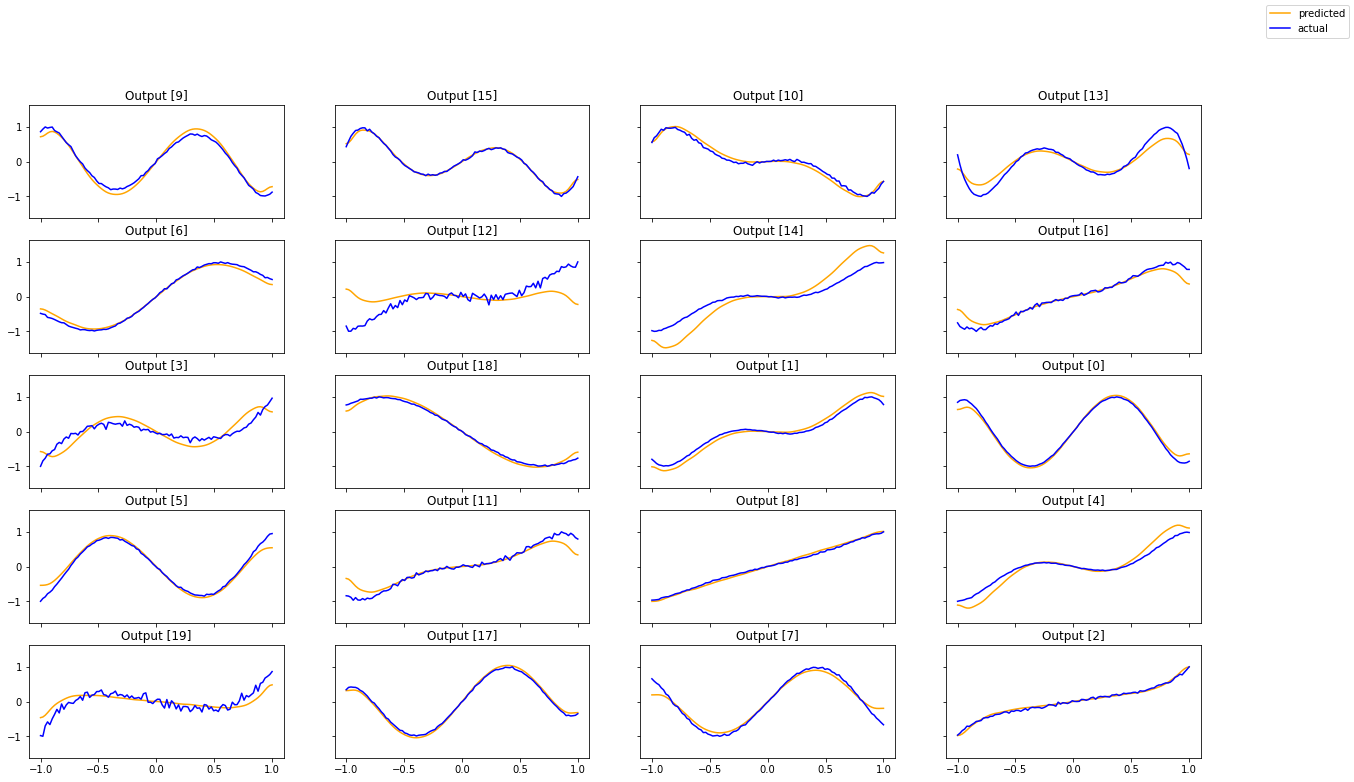

In [30]:
plot_test(test_output, test_y, ty, 5, 4)